In [1]:
lang_suffixes = {"english": "en", "sinhala" : "si", "nepali": "ne"}
from datasets import load_dataset
import pandas as pd 
ds_eng_dev = load_dataset("openlanguagedata/flores_plus", "eng_Latn", split="dev")
ds_sin_dev = load_dataset("openlanguagedata/flores_plus", "sin_Sinh", split="dev")
ds_npi_dev = load_dataset("openlanguagedata/flores_plus", "npi_Deva", split="dev")
eng_lines = [(sentence + "\n") for sentence in list(pd.DataFrame(ds_eng_dev)["text"])]
sin_lines = [(sentence + "\n") for sentence in list(pd.DataFrame(ds_sin_dev)["text"])]
npi_lines = [(sentence + "\n") for sentence in list(pd.DataFrame(ds_npi_dev)["text"])]
with open("data/en-si/eng_Latn.dev", "w", encoding="utf-8") as eng1, open("data/en-ne/eng_Latn.dev", "w", encoding="utf-8") as eng2, open("data/en-si/sin_Sinh.dev", "w", encoding="utf-8") as sin, open("data/en-ne/npi_Deva.dev", "w", encoding="utf-8") as npi:
    eng1.writelines(eng_lines)
    eng2.writelines(eng_lines)
    sin.writelines(sin_lines)
    npi.writelines(npi_lines)
import os 
os.makedirs("evaluation/en-ne/", exist_ok=True)
os.makedirs("evaluation/ne-en/", exist_ok=True)
os.makedirs("evaluation/en-si/", exist_ok=True)
os.makedirs("evaluation/si-en/", exist_ok=True)

/home/tanmay/miniconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import filtering as filtering
def create_corpus_files(list, train=False, langs=["english", "sinhala"]):
    other=""
    for lang in langs:
        if lang!="english":
            other=lang
    lang1_list = list[0].split("\n")
    lang2_list = list[1].split("\n")
    lang1_ids = []
    lang2_ids = []
    for item in lang1_list:
        lang1_ids.append(item.split("\t")[0])
    for item in lang2_list:
        lang2_ids.append(item.split("\t")[0])
    gold_list = list[2].split("\n")
    lang1_corpus_lines = []
    lang2_corpus_lines = []
    for line in lang1_list:
        line = filtering.preprocess_line(line)
        lang1_corpus_lines.append(line)
    for line in lang2_list:
        line = filtering.preprocess_line(line)
        lang2_corpus_lines.append(line)
    addition = "train"
    if train==False: 
        addition = "test"
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{lang_suffixes[langs[0]]}.source_synthetic_corpus.txt", "w", encoding="utf-8") as f:
        for line in lang1_corpus_lines:
            f.write(f"{line}\n")
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{lang_suffixes[langs[1]]}.target_synthetic_corpus.txt", "w", encoding="utf-8") as f:
        for line in lang2_corpus_lines:
            f.write(f"{line}\n")
    return [dict(zip(lang1_ids, lang1_corpus_lines)), dict(zip(lang2_ids, lang2_corpus_lines)), gold_list]

def create_synthetic_corpora(mono_file1, mono_file2, par_file1, par_file2, langs):

    '''Create synthetic parallel corpora to evaluate pipeline by injecting real parallel sentences into different monolingual corpora'''
#
    import bucc_style_dataset as bsd
    lang1_mono_lines = []
    lang2_mono_lines = []
    with open(mono_file1, "r", encoding="utf-8") as f:
        for line in f: 
            line = filtering.preprocess_line(line)
            split = line.split("\t")
            line = line.split("\t")[1]
            lang1_mono_lines.append(split[1])
    with open(mono_file2, "r", encoding="utf-8") as f:
        for line in f:
            line = filtering.preprocess_line(line)
            split  =line.split("\t")
            line = line.split("\t")[1]
            lang2_mono_lines.append(split[1])
    

    lang1_par_lines = []
    lang2_par_lines = []

    with open(par_file1, "r", encoding="utf-8") as f:
        for line in f: 
            line = filtering.preprocess_line(line)
            lang1_par_lines.append(line)
    with open(par_file2, "r", encoding="utf-8") as f:
        for line in f:
            line = filtering.preprocess_line(line)
            lang2_par_lines.append(line)

    train_list, test_list = bsd.split_shuffle_create_corpus(lang1_mono_lines, lang2_mono_lines, lang1_par_lines, lang2_par_lines)
    train_res = create_corpus_files(train_list, train=True)
    test_res = create_corpus_files(test_list, train=False)
    total_res = train_res + test_res
    return total_res

2025-07-07 13:26:34,418 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-07-07 13:26:34,494 | INFO | laser_encoders.download_models |  - laser2.pt already downloaded
2025-07-07 13:26:34,495 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-07-07 13:26:34,496 | INFO | laser_encoders.download_models |  - laser2.cvocab already downloaded
2025-07-07 13:26:35,094 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-07-07 13:26:35,160 | INFO | laser_encoders.download_models |  - laser3-sin_Sinh.v1.pt already downloaded
2025-07-07 13:26:35,161 | INFO | laser_encoders.download_models |  - laser2.spm already downloaded
2025-07-07 13:26:35,161 | INFO | laser_encoders.download_models |  - laser2.cvocab already downloaded


Some weights of XLMRobertaModel were not initialized from the model checkpoint at yihongLiu/furina and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at yihongLiu/furina-indic and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def mine_corpora(lang1_dict, lang2_dict, langs, model, train=False):

    '''Convert synthetic corpora to Word2Vec format to perform sentence mining'''
    addition = ""
    if train==False:
        addition = "test"
    else:
        addition = "train"
    lang1_ids = [key for key, value in lang1_dict.items()]
    lang2_ids = [key for key, value in lang2_dict.items()]
    lang1_vals = [value for key, value in lang1_dict.items()]
    lang2_vals = [value for key, value in lang2_dict.items()]
    import filtering as filtering
    e1 = filtering.to_multilingual_embedding(langs[0], lang1_vals, model)
    e2 = filtering.to_multilingual_embedding(langs[1], lang2_vals, model)  
    source_lines = [f"{e1.shape[0]} {e1.shape[1]}"]
    target_lines = [f"{e2.shape[0]} {e2.shape[1]}"]
    for id, encoding in zip(lang1_ids, e1):
        encoding_str = " ".join([f"{x:.4f}" for x in encoding])
        source_lines.append(f"{id} {encoding_str}")
    for id, encoding in zip(lang2_ids, e2):
        encoding_str = " ".join([f"{x:.4f}" for x in encoding])
        target_lines.append(f"{id} {encoding_str}")  
    other = ""
    for lang in langs: 
        if lang!="english":
            other = lang
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{langs[0]}.{model}.source.vec", "w", encoding="utf-8") as f: 
        for line in source_lines:
            f.write(f"{line}\n")
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{langs[1]}.{model}.target.vec", "w", encoding="utf-8") as f: 
        for line in target_lines:
            f.write(f"{line}\n")
    import bilingual_nearest_neighbor as bnn 
    bnn.main(source_embeddings=f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{langs[0]}.{model}.source.vec", target_embeddings=f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{langs[1]}.{model}.target.vec", output=f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.mined.txt", binary=0, method="csls")

In [4]:
def plot_mining_distribution(file):
    import filtering as filtering 
    import matplotlib.pyplot as plt 
    import numpy as np 
    mining_scores = []
    with open(file, "r", encoding="utf-8") as f:
        for line in f: 
            line = filtering.preprocess_line(line)
            line = line.split("\t")[2]
            mining_scores.append(float(line)) 
    # plt.figure(figsize=(8, 5))
    plt.hist(mining_scores, bins=30, color='skyblue', edgecolor='black')
    plt.title("Distribution of Mining Scores")
    plt.xlabel("Mining Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [5]:
def evaluate_mining(mined_file, lang1_dict, lang2_dict, gold_list, langs, model, training=False, threshold=None):
    import filtering as filtering
    '''Create gold file and prediction file to calculate F-measure'''
    mined_lang1_lines = []
    mined_lang2_lines = []
    mined_scores = []
    with open(mined_file, "r", encoding="utf-8") as f:
        for line in f:
            split = line.split("\t")
            mined_lang1_lines.append(split[0])
            mined_lang2_lines.append(split[1])
            mined_scores.append(float(split[2]))
    import pandas as pd
    df = pd.DataFrame({langs[0]: mined_lang1_lines, langs[1]: mined_lang2_lines, "mining score": mined_scores})
    addition = ""
    if training:
        addition = "train"
        import statistics 
        score_mean = statistics.fmean(mined_scores)
        score_std = statistics.stdev(mined_scores)
        threshold = score_mean + 2*score_std
    else:
        addition = "test"
    # model_thresholds = {"labse": 0.4, "laser": 0.05, "furina": 0.006, "furina-indic": 0.012}
    # threshold = model_thresholds[model]
    df = filtering.static_filter(df, "mining score", threshold)
    # if df.shape[0] > len(gold_list):
    #     df = df[:len(gold_list)]
    other = ""
    for lang in langs: 
        if lang!="english":
            other = lang
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.gold.txt", "w", encoding="utf-8") as f:
        for line in gold_list:
            f.write(f"{line}\n")
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.prediction.txt", "w", encoding="utf-8") as f:
        for line1, line2 in zip(list(df[langs[0]]), list(df[langs[1]])):
            f.write(f"{line1}\t{line2}\n")
    import bucc_f_score as bfs
    bfs.main(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.prediction.txt", f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.gold.txt")
    mined_ids = []
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.prediction.txt", "r", encoding="utf-8") as f:
        for line in f:
            mined_ids.append(filtering.preprocess_line(line))
    with open(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/{addition}.{model}.prediction_text.txt", "w", encoding="utf-8") as f:
        for line in mined_ids:
            split = line.split("\t")
            f.write(f"{lang1_dict[split[0]]}\t{lang2_dict[split[1]]}\n")
    return threshold 


In [6]:
def run_experiment(model, mono1="data/en-si/eng_news_2024_30K-sentences.txt",
                   mono2="data/en-si/sin_wikipedia_2021_30K-sentences.txt",
                   par1="data/en-si/eng_Latn.dev",
                   par2="data/en-si/sin_Sinh.dev", langs=["english", "sinhala"]):
    
    '''Perform the embedding test for a given model'''
    other = ""
    lang_suffixes = {"english": "en", "sinhala" : "si", "nepali": "ne"}
    for lang in langs: 
        if lang!="english":
            other = lang
    res = create_synthetic_corpora(mono1, mono2, par1, par2, langs)
    train_lang1_dict = res[0]
    train_lang2_dict = res[1]
    train_gold_list = res[2]
    test_lang1_dict = res[3]
    test_lang2_dict = res[4]
    test_gold_list = res[5] 
    if (os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/train.{langs[0]}.{model}.source.vec") and 
     os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/train.{langs[1]}.{model}.target.vec") and 
    os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/train.{model}.mined.txt")): 
        print("Skipped corpora mining as results already exist!")
    else: 
        mine_corpora(train_lang1_dict, train_lang2_dict, langs=langs, model=model,train=True)
    plot_mining_distribution(f"evaluation/en-{lang_suffixes[other]}/train.{model}.mined.txt")
    threshold = evaluate_mining(f"evaluation/en-{lang_suffixes[other]}/train.{model}.mined.txt", train_lang1_dict, train_lang2_dict, train_gold_list, langs, model, training=True)
    print(f"Training dataset threshold for similarity score is {threshold}")
    test_gold_list = res[5] 
    if (os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{langs[0]}.{model}.source.vec") and 
     os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{langs[1]}.{model}.target.vec") and 
    os.path.exists(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{model}.mined.txt")): 
        print("Skipped corpora mining as results already exist!")
    else: 
        mine_corpora(test_lang1_dict, test_lang2_dict, langs=langs, model=model,train=False) 
    plot_mining_distribution(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{model}.mined.txt")
    evaluate_mining(f"evaluation/{lang_suffixes[langs[0]]}-{lang_suffixes[langs[1]]}/test.{model}.mined.txt", test_lang1_dict, test_lang2_dict, test_gold_list, langs, model, training=False, threshold=threshold)
    

Batches: 100%|██████████| 243/243 [06:25<00:00,  1.59s/it]


2025-07-06 17:25:07,757 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-07-06 17:25:08,223 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-07-06 17:25:08,242 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-07-06 17:25:08,244 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.english.labse.source.vec
2025-07-06 17:25:09,679 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-si/train.english.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T17:25:09.679662', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 17:25:09

100%|██████████| 7749/7749 [00:00<00:00, 43828.77it/s]

2025-07-06 17:25:12,263 | WARNING | root | Saving results...


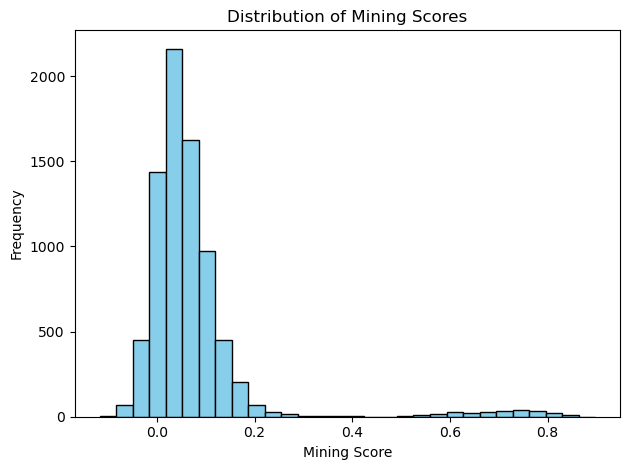

PRECISION,RECALL,F1
0.9763779527559056,0.9959839357429718,0.9860834990059643
Training dataset threshold for similarity score is 0.3234220608973159


Batches: 100%|██████████| 727/727 [20:28<00:00,  1.69s/it]


2025-07-06 18:02:41,905 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.english.labse.source.vec
2025-07-06 18:02:46,130 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-si/test.english.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T18:02:46.130306', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 18:02:46,131 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.sinhala.labse.target.vec
2025-07-06 18:02:50,326 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-si/test.sinhala.labse.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T18:02:50.326460', 'gens

100%|██████████| 23248/23248 [00:00<00:00, 45786.37it/s]

2025-07-06 18:03:01,721 | WARNING | root | Saving results...


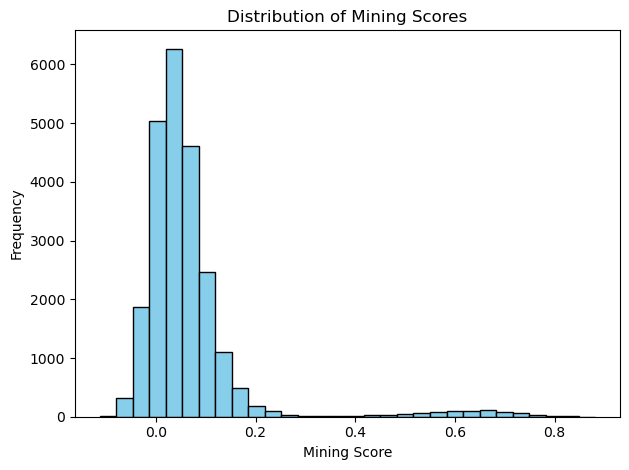

PRECISION,RECALL,F1
0.9906914893617021,0.9959893048128342,0.9933333333333334


In [35]:
run_experiment("labse")

/home/tanmay/miniconda3/envs/thesis_env/lib/python3.9/site-packages/fairseq/models/transformer/transformer_encoder.py:281: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  x = torch._nested_tensor_from_mask(


2025-07-06 18:22:27,002 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.english.laser.source.vec
2025-07-06 18:22:28,692 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 1024) matrix of type float32 from evaluation/en-si/train.english.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T18:22:28.692414', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 18:22:28,693 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.sinhala.laser.target.vec
2025-07-06 18:22:30,391 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 1024) matrix of type float32 from evaluation/en-si/train.sinhala.laser.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T18:22:30.391806', '

100%|██████████| 7749/7749 [00:00<00:00, 44874.20it/s]

2025-07-06 18:22:32,064 | WARNING | root | Saving results...


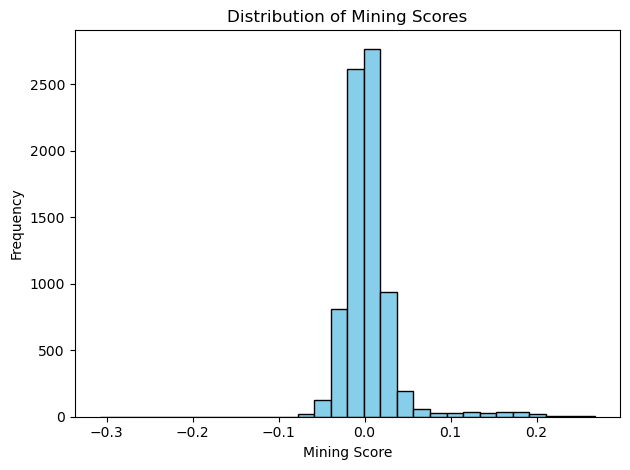

PRECISION,RECALL,F1
0.9224489795918367,0.9076305220883534,0.9149797570850202
Training dataset threshold for similarity score is 0.06826909790592373
2025-07-06 19:14:16,284 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.english.laser.source.vec
2025-07-06 19:14:21,475 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix of type float32 from evaluation/en-si/test.english.laser.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T19:14:21.475268', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 19:14:21,476 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.sinhala.laser.target.vec
2025-07-06 19:14:26,596 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 1024) matrix o

100%|██████████| 23248/23248 [00:00<00:00, 50620.70it/s]

2025-07-06 19:14:41,281 | WARNING | root | Saving results...


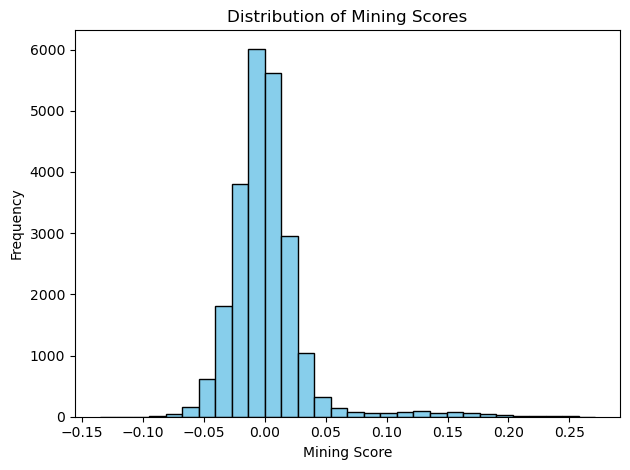

PRECISION,RECALL,F1
0.9272997032640949,0.8355614973262032,0.8790436005625879


In [36]:
run_experiment("laser")

2025-07-06 19:29:31,612 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.english.furina.source.vec
2025-07-06 19:29:32,892 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-si/train.english.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T19:29:32.891971', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 19:29:32,893 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.sinhala.furina.target.vec
2025-07-06 19:29:34,153 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/en-si/train.sinhala.furina.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T19:29:34.153821',

100%|██████████| 7749/7749 [00:00<00:00, 43368.22it/s]

2025-07-06 19:29:35,438 | WARNING | root | Saving results...


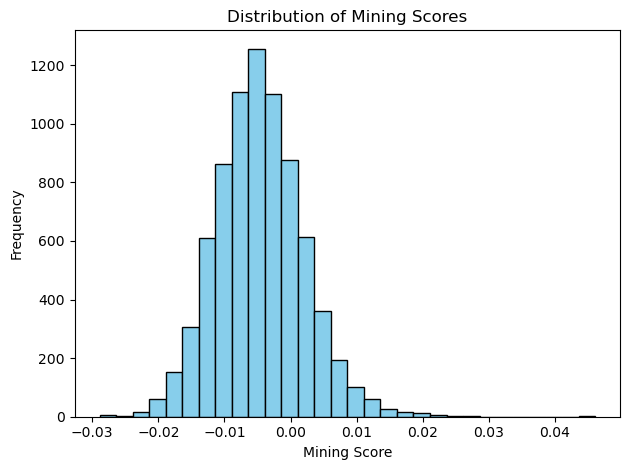

PRECISION,RECALL,F1
0.0625,0.05622489959839357,0.05919661733615222
Training dataset threshold for similarity score is 0.00872797370021191
2025-07-06 20:12:52,493 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.english.furina.source.vec
2025-07-06 20:12:57,889 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-si/test.english.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T20:12:57.889032', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 20:12:57,889 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.sinhala.furina.target.vec
2025-07-06 20:13:01,920 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type fl

100%|██████████| 23248/23248 [00:00<00:00, 52759.00it/s]

2025-07-06 20:13:11,948 | WARNING | root | Saving results...


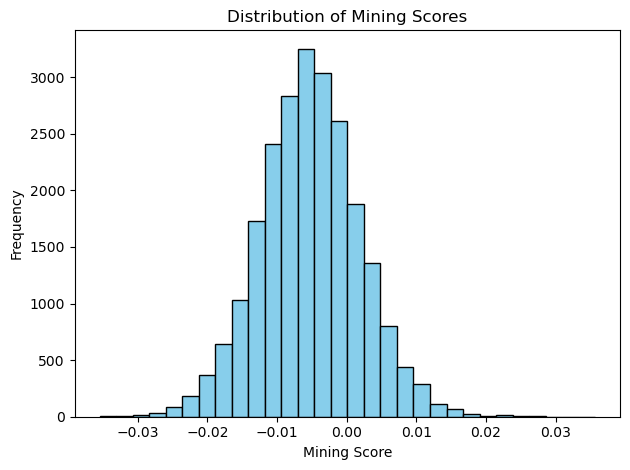

PRECISION,RECALL,F1
0.08500772797527048,0.07352941176470588,0.07885304659498209


In [37]:
run_experiment("furina")

2025-07-06 20:27:55,363 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.english.furina-indic.source.vec
2025-07-06 20:27:56,635 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/en-si/train.english.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T20:27:56.635251', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 20:27:56,636 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/train.sinhala.furina-indic.target.vec
2025-07-06 20:27:57,924 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/en-si/train.sinhala.furina-indic.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025

100%|██████████| 7749/7749 [00:00<00:00, 42637.60it/s]

2025-07-06 20:27:59,244 | WARNING | root | Saving results...


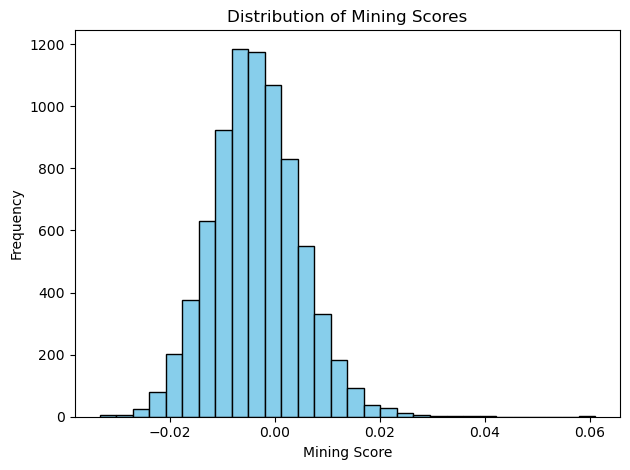

PRECISION,RECALL,F1
0.09389671361502347,0.08032128514056225,0.08658008658008658
Training dataset threshold for similarity score is 0.013101708643548619
2025-07-06 21:11:16,285 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.english.furina-indic.source.vec
2025-07-06 21:11:20,335 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-si/test.english.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T21:11:20.335658', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 21:11:20,336 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-si/test.sinhala.furina-indic.target.vec
2025-07-06 21:11:24,158 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loade

100%|██████████| 23248/23248 [00:00<00:00, 53114.84it/s]

2025-07-06 21:11:33,922 | WARNING | root | Saving results...


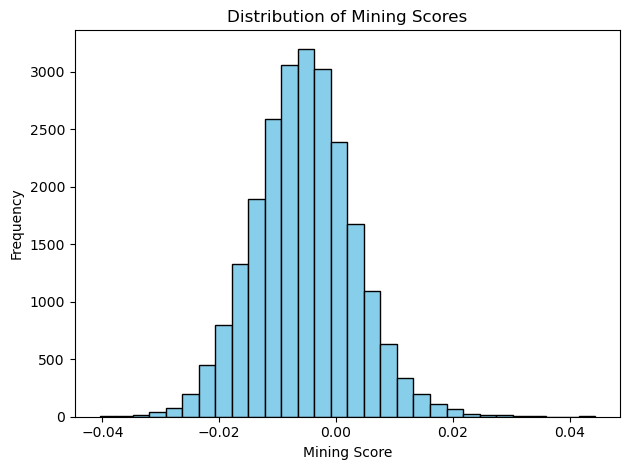

PRECISION,RECALL,F1
0.2119205298013245,0.12834224598930483,0.15986677768526228


In [38]:
run_experiment("furina-indic")
#dfdfdsfdf

Batches: 100%|██████████| 243/243 [05:04<00:00,  1.25s/it]


2025-07-06 21:22:36,695 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.sinhala.labse.source.vec
2025-07-06 21:22:37,920 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/si-en/train.sinhala.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T21:22:37.920757', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 21:22:37,921 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.english.labse.target.vec
2025-07-06 21:22:39,127 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/si-en/train.english.labse.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T21:22:39.127731', 'ge

100%|██████████| 7748/7748 [00:00<00:00, 44724.53it/s]

2025-07-06 21:22:40,378 | WARNING | root | Saving results...


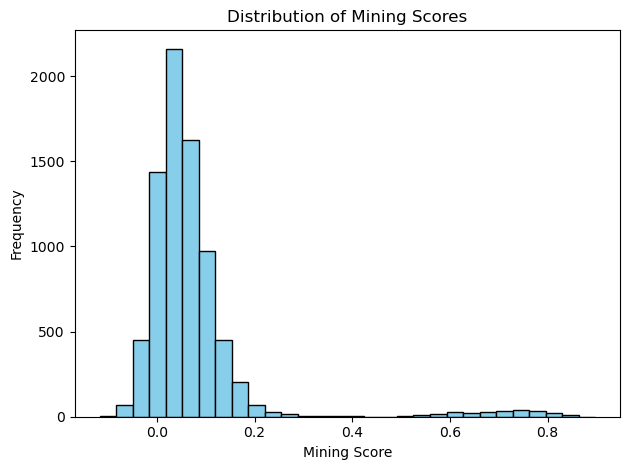

PRECISION,RECALL,F1
0.0,0.0,0.0
Training dataset threshold for similarity score is 0.3234220608973159


Batches: 100%|██████████| 727/727 [14:49<00:00,  1.22s/it]


2025-07-06 21:55:23,609 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.sinhala.labse.source.vec
2025-07-06 21:55:28,732 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/si-en/test.sinhala.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T21:55:28.732316', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 21:55:28,733 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.english.labse.target.vec
2025-07-06 21:55:32,381 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/si-en/test.english.labse.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T21:55:32.381466', 'gens

100%|██████████| 23248/23248 [00:00<00:00, 53630.99it/s]

2025-07-06 21:55:42,073 | WARNING | root | Saving results...


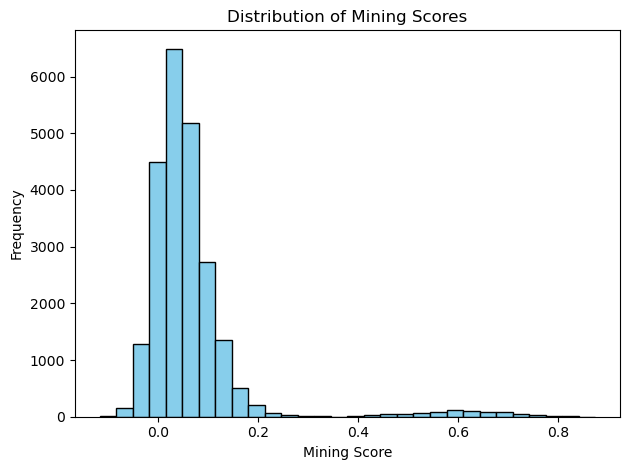

PRECISION,RECALL,F1
0.9906790945406125,0.9946524064171123,0.9926617745163442


In [39]:
run_experiment("labse", 
               "data/en-si/sin_wikipedia_2021_30K-sentences.txt",
               "data/en-si/eng_news_2024_30K-sentences.txt",
               "data/en-si/sin_Sinh.dev",
               "data/en-si/eng_Latn.dev",
               ["sinhala", "english"]
               )

2025-07-06 22:10:00,356 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.sinhala.furina.source.vec
2025-07-06 22:10:03,082 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/si-en/train.sinhala.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T22:10:03.082134', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 22:10:03,082 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.english.furina.target.vec
2025-07-06 22:10:04,292 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/si-en/train.english.furina.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T22:10:04.292097',

100%|██████████| 7748/7748 [00:00<00:00, 47981.47it/s]

2025-07-06 22:10:05,498 | WARNING | root | Saving results...


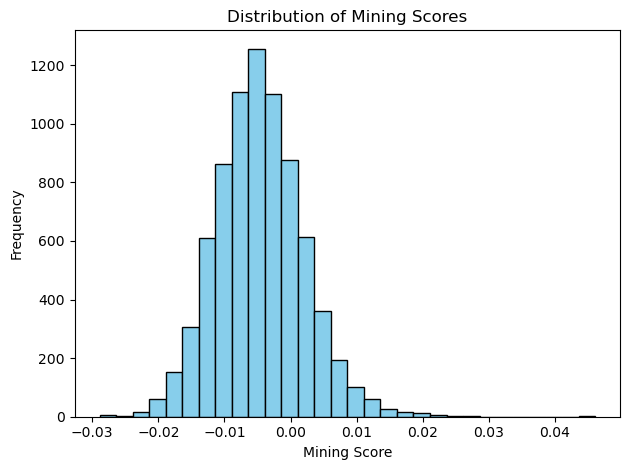

PRECISION,RECALL,F1
0.0,0.0,0.0
Training dataset threshold for similarity score is 0.00872797370021191
2025-07-06 22:52:33,702 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.sinhala.furina.source.vec
2025-07-06 22:52:37,329 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/si-en/test.sinhala.furina.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T22:52:37.329017', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 22:52:37,329 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.english.furina.target.vec
2025-07-06 22:52:41,075 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/si-en/test.en

100%|██████████| 23248/23248 [00:00<00:00, 53902.79it/s]

2025-07-06 22:52:52,380 | WARNING | root | Saving results...


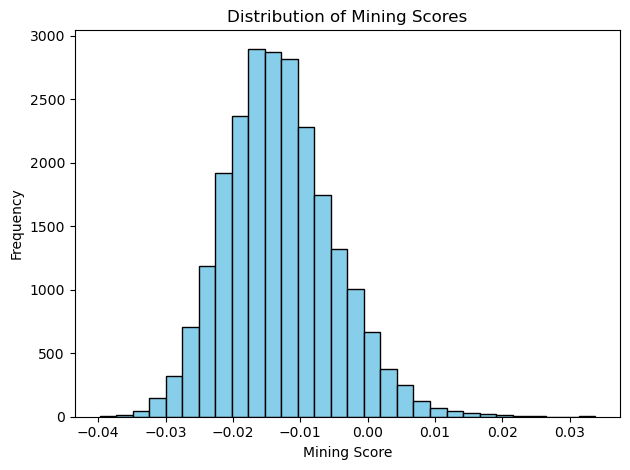

PRECISION,RECALL,F1
0.208955223880597,0.05614973262032086,0.08851422550052687


In [40]:
run_experiment("furina", 
               "data/en-si/sin_wikipedia_2021_30K-sentences.txt",
               "data/en-si/eng_news_2024_30K-sentences.txt",
               "data/en-si/sin_Sinh.dev",
               "data/en-si/eng_Latn.dev",
               ["sinhala", "english"]
               )

2025-07-06 23:07:02,462 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.sinhala.furina-indic.source.vec
2025-07-06 23:07:03,678 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7748, 768) matrix of type float32 from evaluation/si-en/train.sinhala.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T23:07:03.678467', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 23:07:03,679 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/train.english.furina-indic.target.vec
2025-07-06 23:07:04,874 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (7749, 768) matrix of type float32 from evaluation/si-en/train.english.furina-indic.target.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025

100%|██████████| 7748/7748 [00:00<00:00, 48166.66it/s]

2025-07-06 23:07:06,074 | WARNING | root | Saving results...


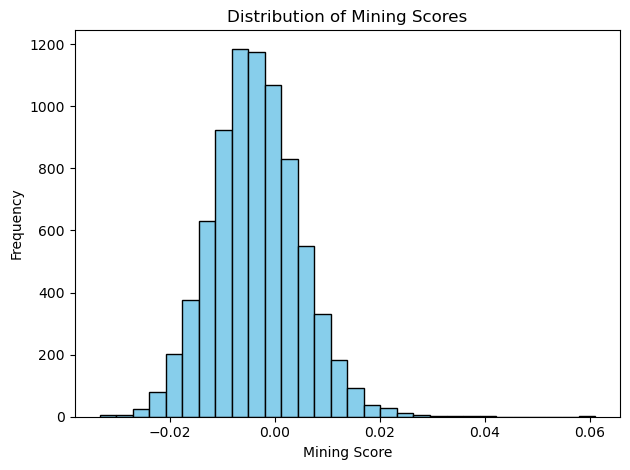

PRECISION,RECALL,F1
0.0,0.0,0.0
Training dataset threshold for similarity score is 0.013101708643548619
2025-07-06 23:58:59,024 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.sinhala.furina-indic.source.vec
2025-07-06 23:59:03,638 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/si-en/test.sinhala.furina-indic.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-06T23:59:03.638349', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-06 23:59:03,639 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/si-en/test.english.furina-indic.target.vec
2025-07-06 23:59:08,388 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evalu

100%|██████████| 23248/23248 [00:00<00:00, 43585.87it/s]

2025-07-06 23:59:21,051 | WARNING | root | Saving results...


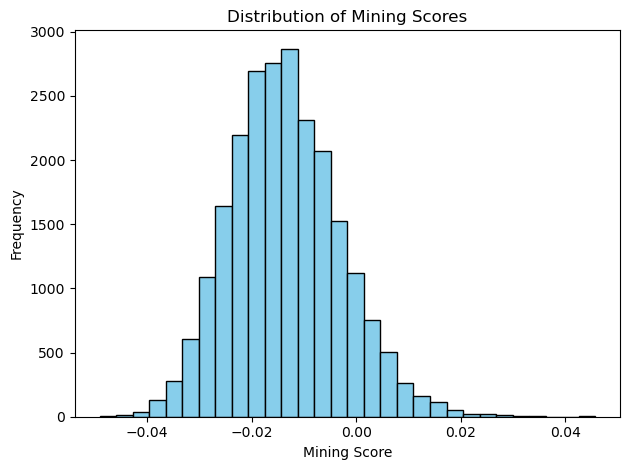

PRECISION,RECALL,F1
0.3079710144927536,0.11363636363636363,0.16601562499999997


In [41]:
run_experiment("furina-indic", 
               "data/en-si/sin_wikipedia_2021_30K-sentences.txt",
               "data/en-si/eng_news_2024_30K-sentences.txt",
               "data/en-si/sin_Sinh.dev",
               "data/en-si/eng_Latn.dev",
               ["sinhala", "english"]
               )

Skipped corpora mining as results already exist!


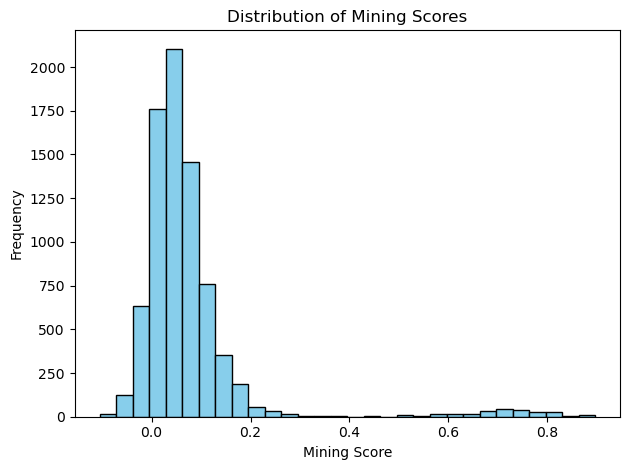

PRECISION,RECALL,F1
0.0,0.0,0.0
Training dataset threshold for similarity score is 0.32906151929083244


Batches: 100%|██████████| 727/727 [17:00<00:00,  1.40s/it]


2025-07-07 14:00:11,140 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-07-07 14:00:11,227 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.
2025-07-07 14:00:11,246 | INFO | faiss | Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
2025-07-07 14:00:11,247 | INFO | gensim.models.keyedvectors | loading projection weights from evaluation/en-ne/test.english.labse.source.vec
2025-07-07 14:00:15,431 | INFO | gensim.utils | KeyedVectors lifecycle event {'msg': 'loaded (23248, 768) matrix of type float32 from evaluation/en-ne/test.english.labse.source.vec', 'binary': 0, 'encoding': 'utf-8', 'datetime': '2025-07-07T14:00:15.431573', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2025-07-07 14:00:15,

100%|██████████| 23248/23248 [00:00<00:00, 48481.45it/s]

2025-07-07 14:00:31,837 | WARNING | root | Saving results...


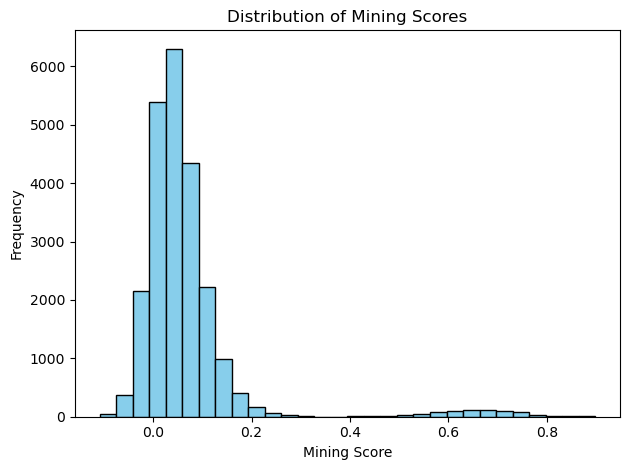

PRECISION,RECALL,F1
0.9959568733153639,0.9879679144385026,0.9919463087248321


In [7]:
run_experiment("labse", 
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_Latn.dev",
               "data/en-ne/npi_Deva.dev",
               ["english", "nepali"]
               )

In [8]:
run_experiment("laser", 
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_Latn.dev",
               "data/en-ne/npi_Deva.dev",
               ["english", "nepali"]
               )

KeyError: 'nepali'

In [ ]:
run_experiment("furina", 
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_Latn.dev",
               "data/en-ne/npi_Deva.dev",
               ["english", "nepali"]
               )

In [ ]:
run_experiment("furina-indic", 
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_Latn.dev",
               "data/en-ne/npi_Deva.dev",
               ["english", "nepali"]
               )

In [ ]:
run_experiment("labse", 
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/npi_Deva.dev",
               "data/en-ne/eng_Latn.dev",
               ["nepali", "english"]
               )

In [ ]:
run_experiment("laser", 
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/npi_Deva.dev",
               "data/en-ne/eng_Latn.dev",
               ["nepali", "english"]
               )

In [ ]:
run_experiment("furina", 
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/npi_Deva.dev",
               "data/en-ne/eng_Latn.dev",
               ["nepali", "english"]
               )

In [ ]:
run_experiment("furina-indic", 
               "data/en-ne/nep_news_2010_30K-sentences.txt",
               "data/en-ne/eng_news_2024_30K-sentences.txt",
               "data/en-ne/npi_Deva.dev",
               "data/en-ne/eng_Latn.dev",
               ["nepali", "english"]
               )